In [143]:
import blocksci
import numpy as np
import pandas as pd 
import scipy 
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
#from sklearn import svm

In [2]:
chain = blocksci.Blockchain("/home/ubuntu/bitcoin")

## Random Stuff/Testing

In [3]:
%time filtered_blocks = chain.map_blocks(lambda block: block.fee/1e9, start = "2017-1-1", end = "2017-12-30") 

CPU times: user 1.94 s, sys: 1.04 s, total: 2.98 s
Wall time: 21.3 s


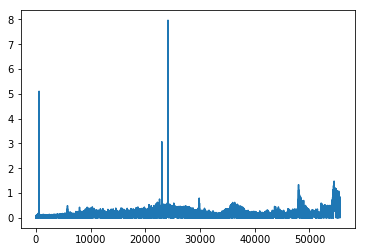

In [4]:
plt.plot(filtered_blocks)

In [9]:
chain.address_count(blocksci.address_type.pubkey)

440796846

In [5]:
%time filtered_blocks = chain.map_blocks(lambda block: block.input_count, start = "2013-1-1", end = "2017-12-30") 

CPU times: user 1.66 s, sys: 280 ms, total: 1.94 s
Wall time: 2.69 s


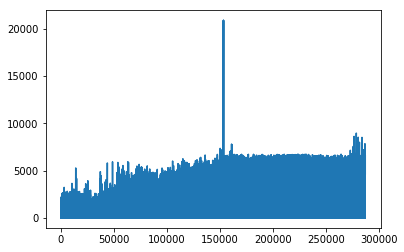

In [6]:
plt.plot(filtered_blocks)

## Average Transaction Size

In [25]:
print(len(chain))

516798


In [15]:
#average size of bitcoin transaction
%time tx_size = [(block.height, np.mean(block.txes.size_bytes)) for block in chain[0:400000]]

CPU times: user 19.6 s, sys: 284 ms, total: 19.8 s
Wall time: 19.4 s


In [140]:
%time tx_size2 = [(block.height, np.mean(block.txes.size_bytes)) for block in chain[400000:510000]]

CPU times: user 21.7 s, sys: 1.11 s, total: 22.8 s
Wall time: 22.2 s


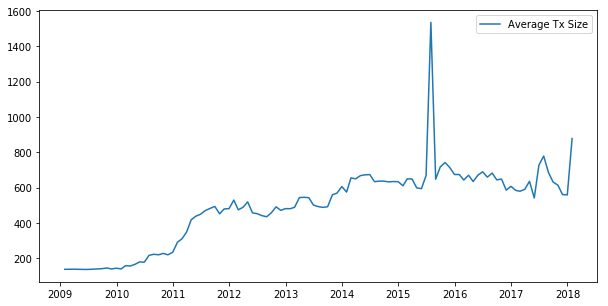

In [141]:
#concatenate lists
avg_tx_size = tx_size + tx_size2
df_avg_size = pd.DataFrame(avg_tx_size, columns=["Height", "Average Tx Size"])
df_avg_size = chain.heights_to_dates(df_avg_size)
#resample by monthly summary.
del df_avg_size["Height"]
df_avg_size = df_avg_size.resample("M").mean()
df_avg_size = df_avg_size[:-1]#drop last row.
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_avg_size)
ax.legend(["Average Tx Size"])

In [45]:
from2015_chain = chain.range('2015-07-07', '2015-07-08')
filtered_txes = [(block.txes, block.txes.size_bytes) for block in from2015_chain]

In [68]:
'''Analysing the spike in the graph.'''
largest_tx_size = 0
indexI, indexJ = 0, 0
for i in range(0, len(filtered_txes)):
    txes = filtered_txes[i]
    for j in range(0, len(txes[1])):
        if txes[1][j] > largest_tx_size:
            largest_tx_size = txes[1][j]
            indexI = i 
            indexJ = j 
            
largest_tx = filtered_txes[indexI][0].all[indexJ]

print("Largest Transaction Size:", largest_tx_size)
print("Largest Transaction:", largest_tx)
print("Largest Transaction Hash:", largest_tx.hash)
print("Height of this Transaction:", largest_tx.block_height)
print("Date received:", largest_tx.block_time)
print("Fee paid by this transaction:", largest_tx.fee)
print("Output value:", largest_tx.output_value)
print("Weight:", largest_tx.weight)

Largest Transaction Size: 999657
Largest Transaction: Tx(len(txins)=5569, len(txouts)=1, size_bytes=999657, block_height=364292, tx_index=74951012)
Largest Transaction Hash: bb41a757f405890fb0f5856228e23b715702d714d59bf2b1feb70d8b2b4e3e08
Height of this Transaction: 364292
Date received: 2015-07-07 18:19:07
Fee paid by this transaction: 0
Output value: 5569000
Weight: 3998628


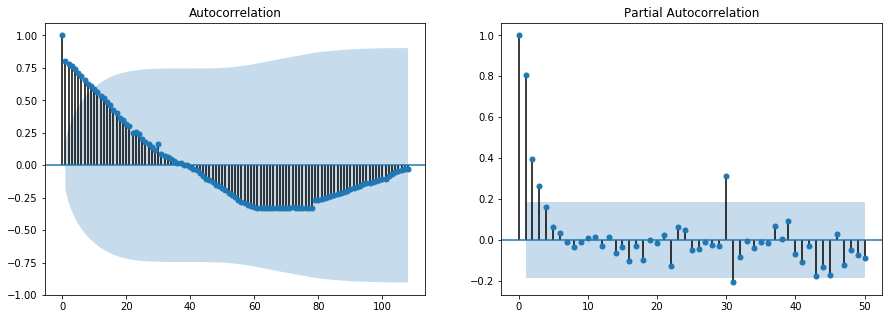

In [208]:
'''Partial and Autocorrelation Plots.'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
plot_acf(df_avg_size['Average Tx Size'], ax = ax1)
plot_pacf(df_avg_size['Average Tx Size'], lags = 50, ax = ax2)
pyplot.show()

                              ARMA Model Results                              
Dep. Variable:        Average Tx Size   No. Observations:                  109
Model:                     ARMA(1, 1)   Log Likelihood                -663.698
Method:                       css-mle   S.D. of innovations            105.556
Date:                Mon, 21 May 2018   AIC                           1335.395
Time:                        11:32:42   BIC                           1346.160
Sample:                    01-31-2009   HQIC                          1339.761
                         - 01-31-2018                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   440.6005    201.170      2.190      0.031      46.314     834.886
ar.L1.Average Tx Size     0.9909      0.011     89.116      0.000       0.969       1.013
ma.L1.Av

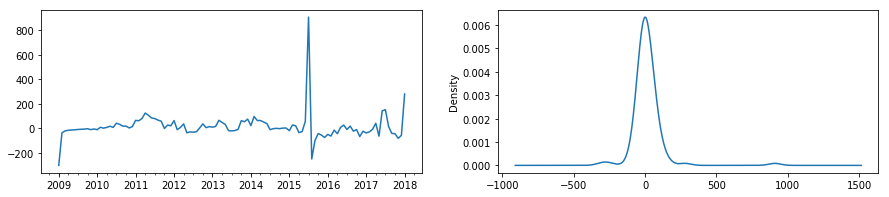

In [228]:
'''Fitting model.'''
model = ARIMA(df_avg_size['Average Tx Size'], order=(1,0,1)) #ARMA(1,1)
model_fit = model.fit(disp=0)
print(model_fit.summary())
#plot residual errors.
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,3))
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(ax = ax1)
residuals.plot(ax = ax2, kind='kde')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

In [240]:
'''Predicting next 3 values.'''
forecasts = model_fit.forecast(steps = 3)
print("3-step forecast: ", forecasts[0])
print("3-step forecast Confidence Intervals: \n", forecasts[2])

3-step forecast:  [ 680.33875814  678.14875894  675.97876528]
3-step forecast Confidence Intervals: 
 [[ 473.45209559  887.22542069]
 [ 462.10676688  894.190751  ]
 [ 451.31062204  900.64690852]]


## Average Transaction Count Per Block

In [44]:
%time tx_count = [(block.height, len(block.txes)) for block in chain[0:400000]]

CPU times: user 6.25 s, sys: 1.24 s, total: 7.49 s
Wall time: 1min 14s


In [42]:
%time tx_count2 = [(block.height, len(block.txes)) for block in chain[400000:510000]]

CPU times: user 8.32 s, sys: 1.7 s, total: 10 s
Wall time: 1min 44s


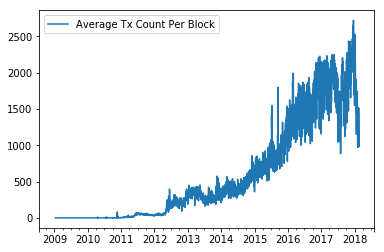

In [46]:
avg_tx_count = tx_count + tx_count2
df_avg_count = pd.DataFrame(avg_tx_count, columns=["Height", "Average Tx Count Per Block"])
df_avg_count = chain.heights_to_dates(df_avg_count)
#resample by daily summary.
del df_avg_count["Height"]
df_avg_count = df_avg_count.resample("d").mean()
df_avg_count.plot()

## Average Fee per Transaction

In [3]:
converter = blocksci.CurrencyConverter()

In [4]:
%time fees = [sum(block.txes.fee) / len(block) for block in chain[0:400000]]
%time times = [block.time for block in chain[0:400000]]

CPU times: user 8.36 s, sys: 540 ms, total: 8.9 s
Wall time: 8.89 s
CPU times: user 660 ms, sys: 432 ms, total: 1.09 s
Wall time: 1.09 s


In [6]:
%time fees2 = [sum(block.txes.fee) / len(block) for block in chain[400000:510000]]
%time times2 = [block.time for block in chain[400000:510000]]

CPU times: user 11.7 s, sys: 1.08 s, total: 12.7 s
Wall time: 12.7 s
CPU times: user 200 ms, sys: 104 ms, total: 304 ms
Wall time: 302 ms


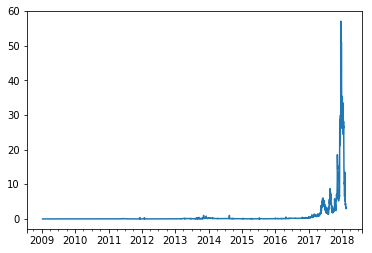

In [60]:
avg_tx_fee = fees + fees2 
dates = times + times2
df_avg_fee = pd.DataFrame({"Fee":avg_tx_fee}, index=dates)
df_avg_fee = converter.satoshi_to_currency_df(df_avg_fee, chain) #convert to USD 
#sample by daily summary 
df_avg_fee = df_avg_fee.resample("d").mean()
df_avg_fee.plot(legend=False)

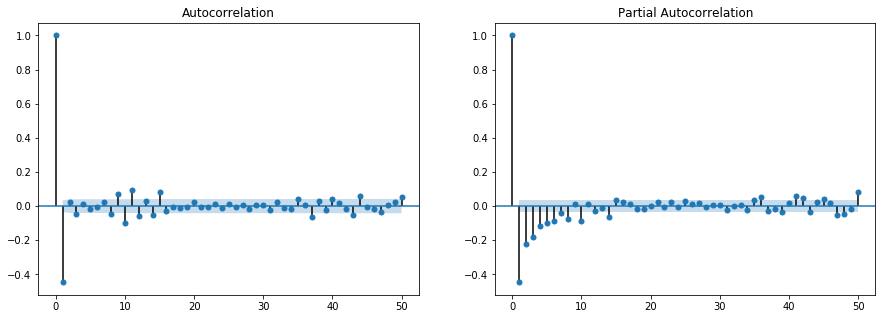

In [61]:
'''Partial and Autocorrelation Plots.'''
df_avg_fee = np.log(df_avg_fee+0.00001) #remove multiplicative effect from the data. 
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
plot_acf(df_avg_fee['Fee'].diff().dropna(), lags = 50, ax = ax1) #ACF and PACF of differenced data 
plot_pacf(df_avg_fee['Fee'].diff().dropna(), lags = 50, ax = ax2)
pyplot.show() #non-stationary linear trend 

                              ARMA Model Results                              
Dep. Variable:                    Fee   No. Observations:                 3328
Model:                     ARMA(2, 1)   Log Likelihood               -1315.140
Method:                       css-mle   S.D. of innovations              0.359
Date:                Tue, 22 May 2018   AIC                           2638.281
Time:                        22:55:49   BIC                           2662.721
Sample:                    01-10-2009   HQIC                          2647.026
                         - 02-19-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.Fee      0.1445      0.027      5.260      0.000       0.091       0.198
ar.L2.Fee      0.0822      0.023      3.574      0.000       0.037       0.127
ma.L1.Fee     -0.7810      0.021    -38.039      0.0

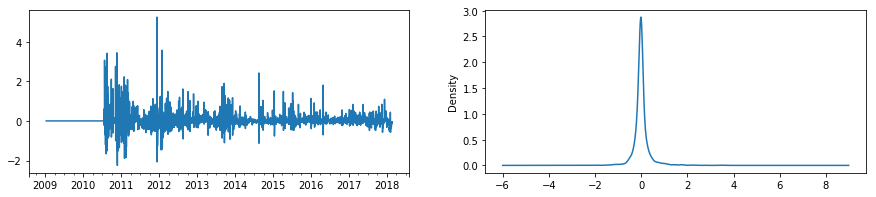

In [66]:
model = ARIMA(df_avg_fee['Fee'].diff().dropna(), order=(2,0,1)) 
model_fit_fee = model.fit(disp=0, trend = 'nc')
print(model_fit_fee.summary())
#plot residual errors.
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,3))
residuals = pd.DataFrame(model_fit_fee.resid)
residuals.plot(ax = ax1)
residuals.plot(ax = ax2, kind='kde')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

In [68]:
'''Predicting next 3 values.'''
forecasts = model_fit_fee.forecast(steps = 3)
print("3-step forecast: ", np.exp(forecasts[0]-0.00001))
print("3-step forecast Confidence Intervals: \n", forecasts[2])

3-step forecast:  [ 1.03783639  1.00993317  1.00448273]
3-step forecast Confidence Intervals: 
 [[-0.66688358  0.74117988]
 [-0.82467107  0.84445939]
 [-0.83011099  0.83907641]]


## Miner's Revenue per Block from 2017

In [3]:
%time miner_revenue = [block.revenue for block in chain.range('2017')]
times = [block.time for block in chain.range('2017')]
#%time miner_revenue2 = [block.revenue for block in chain[400000:510000]]
#times2 = [block.time for block in chain[400000:510000]]

CPU times: user 1.38 s, sys: 772 ms, total: 2.15 s
Wall time: 2.14 s


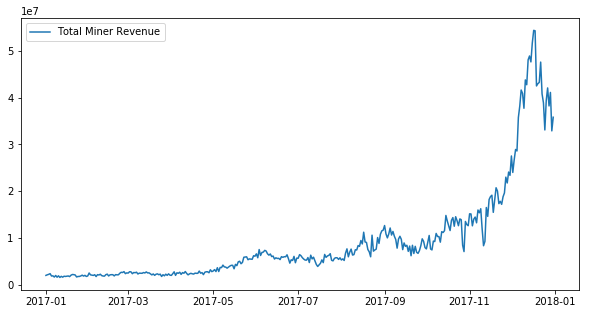

In [6]:
df_miner_rev = pd.DataFrame({"Miner Revenue":miner_revenue}, index=times)
#resample by daily summary.
df_miner_rev = df_miner_rev.resample("d").sum()
df_miner_rev = converter.satoshi_to_currency_df(df_miner_rev, chain.range('2017'))
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_miner_rev)
ax.legend(["Total Miner Revenue"])

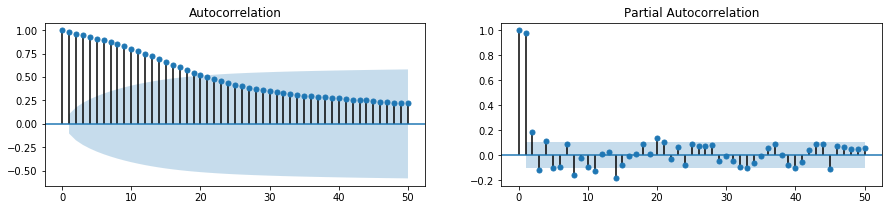

In [12]:
'''Partial and Autocorrelation Plots.'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,3))
plot_acf(df_miner_rev['Miner Revenue'], lags = 50, ax = ax1)
plot_pacf(df_miner_rev['Miner Revenue'], lags = 50, ax = ax2)
pyplot.show() 

                             ARIMA Model Results                              
Dep. Variable:        D.Miner Revenue   No. Observations:                  364
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 235.821
Method:                       css-mle   S.D. of innovations              0.127
Date:                Mon, 21 May 2018   AIC                           -459.643
Time:                        12:11:39   BIC                           -436.260
Sample:                    01-02-2017   HQIC                          -450.349
                         - 12-31-2017                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0079      0.003      2.600      0.010       0.002       0.014
ar.L1.D.Miner Revenue    -0.7845      0.108     -7.283      0.000      -0.996      -0.573
ma.L1.D.

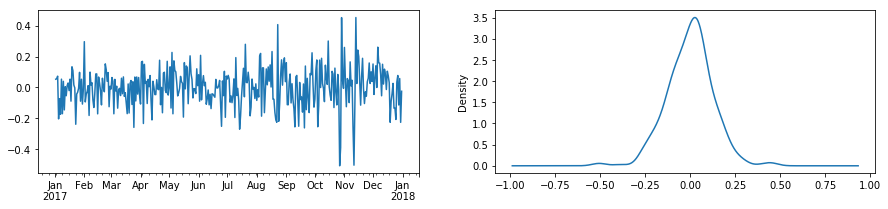

In [50]:
'''Fitting model.'''
df_miner_rev_logged = np.log(df_miner_rev)
model_miner_rev = ARIMA(df_miner_rev_logged['Miner Revenue'], order=(1,1,3)) #ARIMA(1,1,3)
model_fit_miner_rev = model_miner_rev.fit(disp=0)
print(model_fit_miner_rev.summary())
#plot residual errors.
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,3))
residuals = pd.DataFrame(model_fit_miner_rev.resid)
residuals.plot(ax = ax1)
residuals.plot(ax = ax2, kind='kde')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

In [54]:
'''Predicting next 3 values.'''
forecasts = model_fit_miner_rev.forecast(steps = 3)
print("3-step forecast: ", np.exp(forecasts[0]))
print("3-step forecast Confidence Intervals: \n", np.exp(forecasts[2]))

3-step forecast:  [ 36037598.41978846  38282534.99780115  37031208.34413851]
3-step forecast Confidence Intervals: 
 [[ 28123061.22559499  46179485.56339864]
 [ 28760790.82751696  50956612.93345589]
 [ 26951152.53626977  50881326.48804312]]


## Different Types of Address Use

In [3]:
%time net_coins_per_block = chain.map_blocks(lambda block: block.net_address_type_value(), '2009', '2017-12-30')

CPU times: user 11.9 s, sys: 1.12 s, total: 13 s
Wall time: 17.3 s


(0, 13313558.289755534)

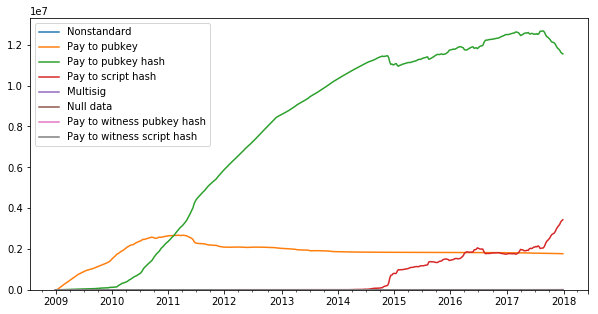

In [4]:
df = pd.DataFrame(net_coins_per_block).fillna(0).cumsum()/1e8
df = chain.heights_to_dates(df)
df = df.rename(columns={t:str(t) for t in df.columns})
ax = df.resample("W").mean().plot(figsize = (10,5))
ax.set_ylim(ymin=0)

## Unspent Transaction Outputs

In [104]:
%time unspent1 = [block.outputs.unspent.all for block in chain[0:400000]]
%time unspent2 = [block.outputs.unspent.all for block in chain[400000:510000]]

CPU times: user 33 s, sys: 404 ms, total: 33.4 s
Wall time: 33.4 s
CPU times: user 30.5 s, sys: 716 ms, total: 31.2 s
Wall time: 31.2 s


In [106]:
%time times = [block.time for block in chain[0:400000]]
%time times2 = [block.time for block in chain[400000:510000]]

CPU times: user 944 ms, sys: 392 ms, total: 1.34 s
Wall time: 1.33 s
CPU times: user 264 ms, sys: 112 ms, total: 376 ms
Wall time: 374 ms


In [107]:
'''Getting the value of these outputs.'''
for txes in unspent1: 
    for i in range(0, len(txes)):
        txes[i] = txes[i].value 
for txes in unspent2:
    for i in range(0, len(txes)):
        txes[i] = txes[i].value

In [109]:
#takes awhile to run. 
unspent = unspent1 + unspent2
times = times + times2
df_unspent = pd.DataFrame({"Value of Unspent Transaction Outputs":unspent[0]}, index=times)
df_unspent = converter.satoshi_to_currency_df(df_unspent, chain) #convert to USD 

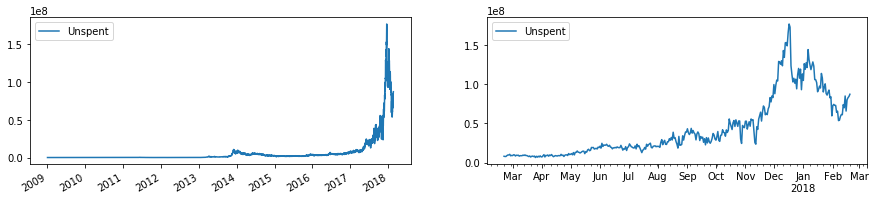

In [142]:
df_unspent = df_unspent.resample("d").sum().dropna()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,3))
df_unspent.plot(ax = ax1)
df_unspent.tail(365).plot(ax = ax2) #plot the last year